MultiRAT analysis code
================
Joanes Grandjean

![rat art](../assets/img/rat_art.png)

# Foreword

This is a jupyter notebook which contains all the code for reproducing my
analysis. The code is meant to be followed step-wise. 

If re-using some of the scripts, please follow citations guidelines for
the software used. I’ve provided the links to the software wherever
possible. See also the [license](../LICENSE.md) for this software.


In [1]:
# init variables
init_folder='/home/traaffneu/joagra/code/MultiRat'
analysis_folder='/project/4180000.19/multiRat'
df_path='../assets/table/multiRat_rest_20211208.tsv'

In [2]:
import os
import pandas as pd
import numpy as np

df = pd.read_csv(df_path, sep='\t')

In [3]:
tsnr_map_path = os.path.join(analysis_folder, 'export', 'snr', 'tsnr')
tsnr_map = os.listdir(tsnr_map_path)

roiL = 520  # left barrel field cortex
roiR = 521  # right barrel field cortex

In [5]:
# create empty tSNR column
df["tsnr.S1"] = np.nan

In [6]:
# read the tSNR file output from RABIES and put them in the correct rows
for i in tsnr_map:
    tnsr_list = pd.read_csv(os.path.join(tsnr_map_path, i),
                            delim_whitespace=True, header=None)
    tsnr_mean = np.mean([tnsr_list[roiL], tnsr_list[roiR]])
    sub=int(i.split('_')[7].split('-')[1])
    ses=int(i.split('_')[8].split('-')[1])
    df.loc[(df['rat.sub'] == sub) & (
        df['rat.ses'] == ses), ['tsnr.S1']]=np.double(tsnr_mean)

In [7]:
# let's do the same for subcortical ROIs
roiL = 731  # Striatum-L
roiR = 732  # Striatum-R

df["tsnr.str"] = np.nan
for i in tsnr_map:
    tnsr_list = pd.read_csv(os.path.join(tsnr_map_path, i),
                            delim_whitespace=True, header=None)
    tsnr_mean = np.mean([tnsr_list[roiL], tnsr_list[roiR]])
    sub=int(i.split('_')[7].split('-')[1])
    ses=int(i.split('_')[8].split('-')[1])
    df.loc[(df['rat.sub'] == sub) & (
        df['rat.ses'] == ses), ['tsnr.str']]=np.double(tsnr_mean)

In [5]:
# then we extract the mean and max framewise displacement
MFW_map_path = os.path.join(analysis_folder, 'export', 'motion', 'FD')
MFW_map = os.listdir(MFW_map_path)

df[""] = np.nan
df["maxFW"] = np.nan
for i in MFW_map:
    MFW_list = pd.read_csv(os.path.join(MFW_map_path, i),
                            delim_whitespace=False)
    MFW_mean = np.mean(MFW_list['Mean'])
    MFW_max = np.max(MFW_list['Mean'])
    sub=int(i.split('_')[0].split('-')[1])
    ses=int(i.split('_')[1].split('-')[1])
    df.loc[(df['rat.sub'] == sub) & (
        df['rat.ses'] == ses), ['MFW']]=np.double(MFW_mean)
    df.loc[(df['rat.sub'] == sub) & (
        df['rat.ses'] == ses), ['maxFW']]=np.double(MFW_max)


In [6]:
df.to_csv(df_path, sep='\t', index=False)

In [4]:
#remove excluded scans
df_exclude = df.loc[(df['exclude'] != 'yes')]

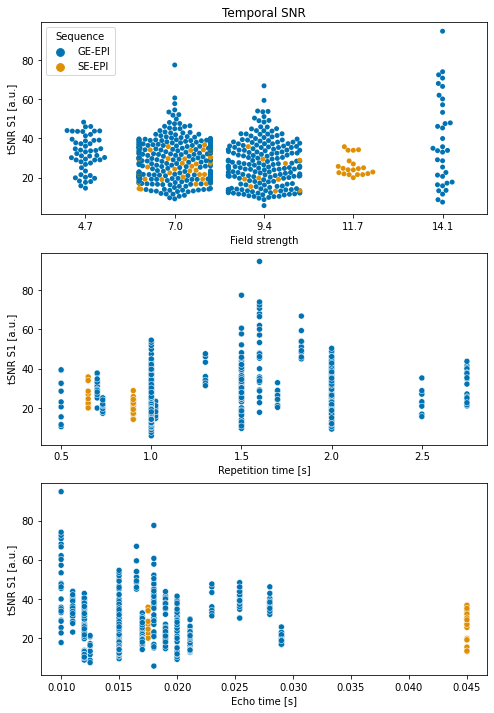

In [5]:
# plot S1 tSNR as a function of acquisition parameters

import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8, 12))

sns.set_palette("colorblind")


ax1 = sns.swarmplot(data=df_exclude, x="MRI.field.strength",
                    y="tsnr.S1", hue="func.sequence",ax=axes[0])
ax2 = sns.scatterplot(data=df_exclude, x="func.TR",
                    y="tsnr.S1", hue="func.sequence",ax=axes[1])
ax3 = sns.scatterplot(data=df_exclude, x="func.TE",
                    y="tsnr.S1", hue="func.sequence",ax=axes[2])


ax1.set(xlabel='Field strength', ylabel='tSNR S1 [a.u.]', title='Temporal SNR')
ax1.get_legend().set_title('Sequence')

ax2.set(xlabel='Repetition time [s]', ylabel='tSNR S1 [a.u.]')
ax2.get_legend().remove()

ax3.set(xlabel='Echo time [s]', ylabel='tSNR S1 [a.u.]')
ax3.get_legend().remove()

correlation between tSNR in cortex and striatum
0.8961133168384888


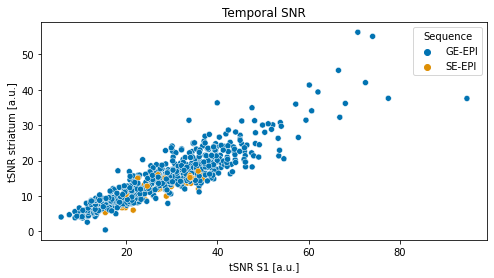

In [12]:
# does tSNR in the cortex correlate to tSNR in the striatum?
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))

sns.set_palette("colorblind")
print('correlation between tSNR in cortex and striatum')
print(df_exclude[['tsnr.S1','tsnr.str']].corr().iloc[0,1])

ax1 = sns.scatterplot(data=df_exclude, x="tsnr.S1",
                    y="tsnr.str", hue="func.sequence")

ax1.set(xlabel='tSNR S1 [a.u.]', ylabel='tSNR striatum [a.u.]', title='Temporal SNR')
ax1.get_legend().set_title('Sequence')

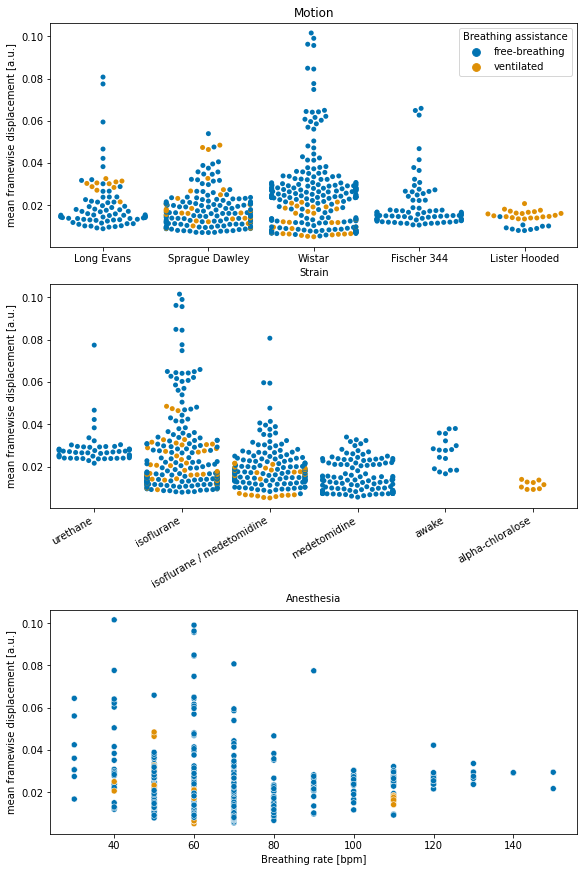

In [13]:
# plot mean framewise displacement as a function of acquisition parameters

import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8, 12),constrained_layout=True)

sns.set_palette("colorblind")


ax1 = sns.swarmplot(data=df_exclude, x="rat.strain",
                    y="MFW", hue="anesthesia.breathing.assistance",ax=axes[0])
ax2 = sns.swarmplot(data=df_exclude, x="anesthesia.maintenance",
                    y="MFW", hue="anesthesia.breathing.assistance",ax=axes[1])
ax3 = sns.scatterplot(data=df_exclude, x="anesthesia.breathing.rate",
                    y="MFW", hue="anesthesia.breathing.assistance",ax=axes[2])


ax1.set(xlabel='Strain', ylabel='mean framewise displacement [a.u.]', title='Motion')
ax1.get_legend().set_title('Breathing assistance')

ax2.set(xlabel='Anesthesia', ylabel='mean framewise displacement [a.u.]')
ax2.get_legend().remove()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right')

ax3.set(xlabel='Breathing rate [bpm]', ylabel='mean framewise displacement [a.u.]')
ax3.get_legend().remove()

correlation between mean and max FW
0.5976719356349767


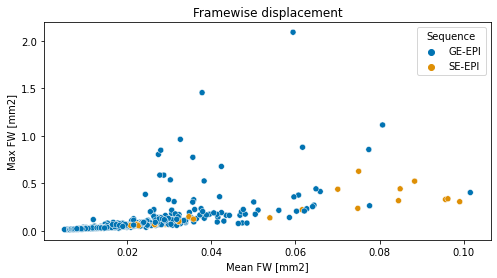

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns


# does mean FW correlate to max FW?
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))

sns.set_palette("colorblind")
print('correlation between mean and max FW')
print(df_exclude[['MFW','maxFW']].corr().iloc[0,1])

ax1 = sns.scatterplot(data=df_exclude, x="MFW",
                    y="maxFW", hue="func.sequence")

ax1.set(xlabel='Mean FW [mm2]', ylabel='Max FW [mm2]', title='Framewise displacement')
ax1.get_legend().set_title('Sequence')

In [7]:

df_exclude.columns=df_exclude.columns.str.replace('[\.]', '')

In [14]:
# testing the impact of acquisition parameters on tSNR. 
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.api import qqplot

df_exclude.columns=df_exclude.columns.str.replace('[\.]', '')

print('testing for the effect of field strength')
m01 = ols('tsnrS1 ~ MFW+ MRIfieldstrength + funcsequence + funcTR + funcTE', data=df_exclude).fit()
m02 = ols('tsnrS1 ~ MFW+funcsequence + funcTR + funcTE', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('mean framwise displacement')
m02 = ols('tsnrS1 ~ funcsequence+MRIfieldstrength + funcTR + funcTE', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of sequence')
m02 = ols('tsnrS1 ~ MFW+MRIfieldstrength + funcTR + funcTE', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of TR')
m02 = ols('tsnrS1 ~ MFW+MRIfieldstrength + funcsequence + funcTE', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of TE')
m02 = ols('tsnrS1 ~ MFW+MRIfieldstrength + funcsequence + funcTR', data=df_exclude).fit()
print(anova_lm(m02, m01))

fig = qqplot(m01.resid,fit=True, line="45")
plt.show()


testing for the effect of field strength
   df_resid           ssr  df_diff    ss_diff        F    Pr(>F)
0     600.0  78464.584940      0.0        NaN      NaN       NaN
1     599.0  78434.892355      1.0  29.692585  0.22676  0.634111

mean framwise displacement
   df_resid           ssr  df_diff    ss_diff         F    Pr(>F)
0     600.0  78454.125092      0.0        NaN       NaN       NaN
1     599.0  78434.892355      1.0  19.232737  0.146879  0.701672

testing for the effect of sequence
   df_resid           ssr  df_diff     ss_diff         F    Pr(>F)
0     600.0  78710.662884      0.0         NaN       NaN       NaN
1     599.0  78434.892355      1.0  275.770529  2.106034  0.147243

testing for the effect of TR
   df_resid           ssr  df_diff      ss_diff          F        Pr(>F)
0     600.0  82761.805710      0.0          NaN        NaN           NaN
1     599.0  78434.892355      1.0  4326.913355  33.044236  1.435819e-08

testing for the effect of TE
   df_resid           

In the above code, I perform likelihood test ratios to determine the effect of several factors of interest onto tSNR. Unfortunately, the initial model is rather poor and possibly insufficient to determine any inferences. I will therefore not use these results in the final analysis for the manuscript. Same with motion parameters below. 

In [6]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

df_exclude.columns=df_exclude.columns.str.replace('[\.]', '')

print('testing for the effect of strain')
m01 = ols('MFW ~ ratstrain+ ratsex+ ratweight + anesthesiamaintenance + anesthesiabreathingassistance + anesthesiabreathingrate', data=df_exclude).fit()
m02 = ols('MFW ~ ratsex+ ratweight + anesthesiamaintenance + anesthesiabreathingassistance + anesthesiabreathingrate', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of sex')
m02 = ols('MFW ~ ratstrain+  ratweight + anesthesiamaintenance + anesthesiabreathingassistance + anesthesiabreathingrate', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of weight')
m02 = ols('MFW ~ ratstrain+ ratsex+ anesthesiamaintenance + anesthesiabreathingassistance + anesthesiabreathingrate', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of anesthesia maintenance')
m02 = ols('MFW ~ ratstrain+ ratsex+ ratweight + anesthesiabreathingassistance + anesthesiabreathingrate', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of breathing assistance')
m02 = ols('MFW ~ ratstrain+ ratsex+ ratweight + anesthesiamaintenance +  anesthesiabreathingrate', data=df_exclude).fit()
print(anova_lm(m02, m01))

print('')
print('testing for the effect of breathing rate')
m02 = ols('MFW ~ ratstrain+ ratsex+ ratweight + anesthesiamaintenance +  anesthesiabreathingassistance', data=df_exclude).fit()
print(anova_lm(m02, m01))

fig = qqplot(m01.resid,fit=True, line="45")
plt.show()


testing for the effect of strain
   df_resid       ssr  df_diff   ss_diff        F    Pr(>F)
0     431.0  0.082166      0.0       NaN      NaN       NaN
1     427.0  0.080279      4.0  0.001887  2.50904  0.041396

testing for the effect of sex
   df_resid       ssr  df_diff   ss_diff          F    Pr(>F)
0     428.0  0.083363      0.0       NaN        NaN       NaN
1     427.0  0.080279      1.0  0.003084  16.406083  0.000061

testing for the effect of weight
   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0     497.0  0.098671      0.0       NaN       NaN       NaN
1     427.0  0.080279     70.0  0.018392  1.397528  0.025562

testing for the effect of anesthesia maintenance
   df_resid       ssr  df_diff   ss_diff          F        Pr(>F)
0     431.0  0.095959      0.0       NaN        NaN           NaN
1     427.0  0.080279      4.0  0.015681  20.851085  1.027025e-15

testing for the effect of breathing assistance
   df_resid       ssr  df_diff   ss_diff        F    Pr(>